In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)

from sklearn.preprocessing import LabelEncoder
import time

In [12]:
df_1 = pd.read_csv('CIC-IDS-2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df_2 = pd.read_csv('CIC-IDS-2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df_3 = pd.read_csv('CIC-IDS-2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')
df_4 = pd.read_csv('CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv')
df_5 = pd.read_csv('CIC-IDS-2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df_6 = pd.read_csv('CIC-IDS-2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df_7 = pd.read_csv('CIC-IDS-2017/Tuesday-WorkingHours.pcap_ISCX.csv')
df_8 = pd.read_csv('CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv')

In [13]:
df_1 = df_1[0:20000]

In [14]:
df_2 = df_2[50000:100000]

In [15]:
df_3 = df_3[50000:100000]

# Data Preprocessing

In [16]:
# get shapes of each dataframe's
for i in range(1, 9):
    df_name = f'df_{i}'
    current_df = globals()[df_name]
    print(f"{df_name}: {current_df.shape}")

df_1: (20000, 79)
df_2: (50000, 79)
df_3: (50000, 79)
df_4: (529918, 79)
df_5: (288602, 79)
df_6: (170366, 79)
df_7: (445909, 79)
df_8: (692703, 79)


## 1.1 Data Concatenation, dropping of duplicated rows and features with constant values

In [17]:
# Concatenates all data frames
main_df = pd.concat([df_1, df_2, df_3, df_5, df_6, df_7, df_8])
main_df = main_df.reset_index()


# Drop duplicates: same observation but multiple occurences
main_df_1 = main_df.drop_duplicates(keep='first')


# Drop columns that have just one unique value, the model wont learn form columns like this.
one_value = main_df_1.columns[main_df_1.nunique() == 1]
main_df_2 = main_df_1.drop(columns = one_value, axis=1)


# Fill nan values
#main_df_2['Flow Bytes/s'] = main_df_2['Flow Bytes/s'].fillna(main_df_2['Flow Bytes/s'].mean())


# Remove leading space character in all feature names
main_df_2.rename(columns=lambda x: x.lstrip(), inplace=True)


# Drop columns
main_df_2 = main_df_2.drop(['Flow Packets/s', 'Flow Bytes/s'], axis=1)

main_df_2.shape

(1717577, 70)

In [18]:
# Checking numbers of missing values on the df
main_df_2.isna().sum().sum()

0

# 1.2 Extract subsample of data
Getting a subsample of the data, while taking every unique values in the Label(Target) column into consideration.

In [19]:
main_df_2['Label'].value_counts()

BENIGN                        1435043
DoS Hulk                       231073
PortScan                        12254
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Web Attack � Brute Force         1507
DDoS                             1117
Web Attack � XSS                  652
Bot                               440
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

In [20]:
df = main_df_2

In [21]:
df = df.sample(frac = 1)

In [22]:
# changing attack labels to their respective attack class
def change_label(df):
  df.Label.replace(['Web Attack � Brute Force'],'Brute Force',inplace=True)
  df.Label.replace(['Web Attack � XSS'],'XSS',inplace=True)      
  df.Label.replace(['Web Attack � Sql Injection'],'Sql Injection',inplace=True)

In [23]:
change_label(df)

In [24]:
df['Label'].value_counts()

BENIGN              1435043
DoS Hulk             231073
PortScan              12254
DoS GoldenEye         10293
FTP-Patator            7938
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Brute Force            1507
DDoS                   1117
XSS                     652
Bot                     440
Infiltration             36
Sql Injection            21
Heartbleed               11
Name: Label, dtype: int64

In [25]:
df.head()

,index,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
687465,108497,443,1399632,11,9,530,3848,197,0,48.181818,71.810609,1460,0,427.555556,612.214854,7.366484e+04,1.721453e+05,727976,1,1399632,139963.2,2.217936e+05,727976,3,1160401,145050.125,259838.48650,743115,1,0,0,232,192,7.859209,6.430262,0,1460,208.476191,436.353368,1.904043e+05,0,0,0,1,0,0,0,0,0,218.900000,48.181818,427.555556,232,11,530,9,3848,8192,31,5,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1248864,223987,80,98408719,7,5,312,11595,306,0,44.571429,115.300849,7240,0,2319.000000,3331.638186,8.946247e+06,2.970000e+07,98400000,1,98400000,16400000.0,4.020000e+07,98400000,1,41433,10358.250,13762.40743,29229,85,0,0,220,168,0.071132,0.050809,0,7240,915.923077,2244.917091,5.039653e+06,0,0,0,0,1,0,0,0,0,992.250000,44.571429,2319.000000,220,7,312,5,11595,251,235,2,20,1003.0,0.0,1003,1003,98400000.0,0.0,98400000,98400000,DoS Hulk
587943,8975,443,16463,3,0,53,0,53,0,17.666667,30.599564,0,0,0.000000,0.000000,8.231500e+03,1.157322e+04,16415,48,16463,8231.5,1.157322e+04,16415,48,0,0.000,0.00000,0,0,0,0,60,0,182.226812,0.000000,0,53,13.250000,26.500000,7.022500e+02,0,0,0,0,1,0,0,0,0,17.666667,17.666667,0.000000,60,3,53,0,0,64240,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9794,9794,53,266,2,2,62,264,31,31,31.000000,0.000000,132,132,132.000000,0.000000,8.866667e+01,7.043673e+01,170,48,48,48.0,0.000000e+00,48,48,48,48.000,0.00000,48,48,0,0,64,64,7518.796992,7518.796992,31,132,71.400000,55.319978,3.060300e+03,0,0,0,0,0,0,0,0,1,89.250000,31.000000,132.000000,64,2,62,2,264,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1479069,454192,53,143176,1,1,40,149,40,40,40.000000,0.000000,149,149,149.000000,0.000000,1.431760e+05,0.000000e+00,143176,143176,0,0.0,0.000000e+00,0,0,0,0.000,0.00000,0,0,0,0,32,32,6.984411,6.984411,40,149,76.333333,62.931179,3.960333e+03,0,0,0,0,0,0,0,0,1,114.500000,40.000000,149.000000,32,1,40,1,149,-1,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [26]:
df.to_csv('processed_cicids2017.csv')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717577 entries, 687465 to 214297
Data columns (total 70 columns):
index                          int64
Destination Port               int64
Flow Duration                  int64
Total Fwd Packets              int64
Total Backward Packets         int64
Total Length of Fwd Packets    int64
Total Length of Bwd Packets    int64
Fwd Packet Length Max          int64
Fwd Packet Length Min          int64
Fwd Packet Length Mean         float64
Fwd Packet Length Std          float64
Bwd Packet Length Max          int64
Bwd Packet Length Min          int64
Bwd Packet Length Mean         float64
Bwd Packet Length Std          float64
Flow IAT Mean                  float64
Flow IAT Std                   float64
Flow IAT Max                   int64
Flow IAT Min                   int64
Fwd IAT Total                  int64
Fwd IAT Mean                   float64
Fwd IAT Std                    float64
Fwd IAT Max                    int64
Fwd IAT Min     

In [28]:
df = df[0:500000]

In [29]:
df['Label'].value_counts()

BENIGN              417727
DoS Hulk             67369
PortScan              3550
DoS GoldenEye         2992
FTP-Patator           2299
SSH-Patator           1700
DoS slowloris         1633
DoS Slowhttptest      1629
Brute Force            423
DDoS                   340
XSS                    195
Bot                    126
Infiltration             8
Sql Injection            5
Heartbleed               4
Name: Label, dtype: int64

In [30]:
len(df['Label'].value_counts())

15

In [31]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['Label']= label_encoder.fit_transform(df['Label'])

df['Label'].unique()

array([ 0,  5,  8,  4, 12, 11,  6,  1,  7, 14,  2, 13,  3,  9, 10],
      dtype=int64)

# Feature Selection

In [32]:
X = df.drop(["Label"],axis =1)
y = df["Label"]

In [33]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif

selector = SelectPercentile(mutual_info_classif, percentile=20)
X_reduced = selector.fit_transform(X, y)
X_reduced.shape


(500000, 14)

In [34]:
cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()
selected_columns

['Flow Duration',
 'Total Length of Bwd Packets',
 'Bwd Packet Length Mean',
 'Flow IAT Mean',
 'Flow IAT Max',
 'Fwd IAT Max',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'Average Packet Size',
 'Avg Bwd Segment Size',
 'Subflow Bwd Bytes',
 'Init_Win_bytes_forward']

In [35]:
df = df[['Flow Duration',
                 'Total Length of Bwd Packets',
                 'Bwd Packet Length Mean',
                 'Flow IAT Mean',
                 'Flow IAT Max',
                 'Fwd IAT Max',
                 'Max Packet Length',
                 'Packet Length Mean',
                 'Packet Length Std',
                 'Packet Length Variance',
                 'Average Packet Size',
                 'Avg Bwd Segment Size',
                 'Subflow Bwd Bytes',
                 'Init_Win_bytes_forward',
                  'Label']]
df.to_csv('cicids2017_red.csv')

In [36]:
from sklearn.model_selection import train_test_split
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.20, random_state=42)

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [38]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# SVM

In [39]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svc_acc = accuracy_score(y_pred, y_test)
svc_prec = precision_score(y_pred, y_test,average='weighted')
svc_rec = recall_score(y_pred, y_test,average='weighted')
svc_f1 = f1_score(y_pred, y_test,average='weighted')

In [40]:
storeResults('SVM',svc_acc,svc_prec,svc_rec,svc_f1)

# Bagging Classifier

In [41]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

clf = BaggingClassifier(RandomForestClassifier(),n_estimators=10, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

bag_acc = accuracy_score(y_pred, y_test)
bag_prec = precision_score(y_pred, y_test,average='weighted')
bag_rec = recall_score(y_pred, y_test,average='weighted')
bag_f1 = f1_score(y_pred, y_test,average='weighted')

In [42]:
storeResults('Bagging Classifier',bag_acc,bag_prec,bag_rec,bag_f1)

# Voting Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

clf1 = BaggingClassifier(RandomForestClassifier(),n_estimators=10, random_state=0)
clf2 = DecisionTreeClassifier(random_state=10)

eclf1 = VotingClassifier(estimators=[('bagging', clf1), ('dt', clf2)], voting='soft')
eclf1.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)

vot_acc = accuracy_score(y_pred, y_test)
vot_prec = precision_score(y_pred, y_test,average='weighted')
vot_rec = recall_score(y_pred, y_test,average='weighted')
vot_f1 = f1_score(y_pred, y_test,average='weighted')

In [44]:
vot_acc

0.99725

In [45]:
storeResults('Voting Classifier',vot_acc,vot_prec,vot_rec,vot_f1)

# DL

In [46]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.20, random_state=42)

In [48]:
#X_train=X_train.values
#X_test=X_test.values

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

# LSTM

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.layers import Dropout
from keras import regularizers
import tensorflow as tf

In [50]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras import regularizers
import tensorflow as tf

# define a function to build the keras model
def create_model(input_shape):
    # create model
    d = 0.25
    model = Sequential()
    
    model.add(LSTM(32, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(256, input_shape=input_shape, activation='relu', return_sequences=False))
    model.add(Dropout(d))
   
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # compile model
    adam = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.00001)
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(input_shape=(14,1))
#print(model.summary())

In [51]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=5, batch_size=5, verbose=1, steps_per_epoch=500, validation_steps=500)

Epoch 1/5
500/500 [==============================] - 45s 40ms/step - loss: 1.0648e-07 - accuracy: 0.7537 - val_loss: 1.0476e-07 - val_accuracy: 0.7656
Epoch 2/5
500/500 [==============================] - 18s 35ms/step - loss: 1.0299e-07 - accuracy: 0.7566 - val_loss: 1.0476e-07 - val_accuracy: 0.7656
Epoch 3/5
500/500 [==============================] - 17s 35ms/step - loss: 1.0577e-07 - accuracy: 0.7499 - val_loss: 1.0476e-07 - val_accuracy: 0.7656
Epoch 4/5
500/500 [==============================] - 21s 43ms/step - loss: 1.0747e-07 - accuracy: 0.7568 - val_loss: 1.0476e-07 - val_accuracy: 0.7656
Epoch 5/5
500/500 [==============================] - 18s 36ms/step - loss: 1.0951e-07 - accuracy: 0.7351 - val_loss: 1.0476e-07 - val_accuracy: 0.7656


In [52]:
import matplotlib.pyplot as plt

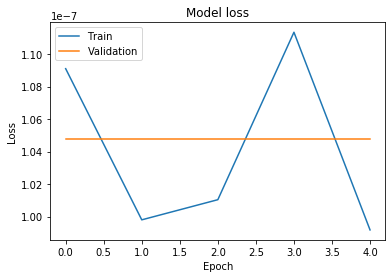

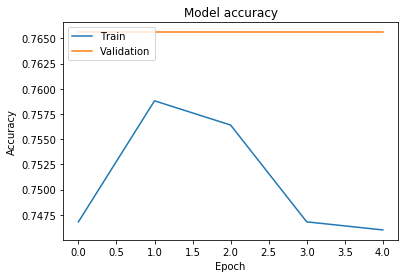

In [53]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [54]:
y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

lstm_acc = accuracy_score(y_pred, y_test)
lstm_prec = precision_score(y_pred, y_test,average='weighted')
lstm_rec = recall_score(y_pred, y_test,average='weighted')
lstm_f1 = f1_score(y_pred, y_test,average='weighted')

3125/3125 [==============================] - 56s 17ms/step


In [55]:
storeResults('LSTM',lstm_acc,lstm_prec,lstm_rec,lstm_f1)

# RNN

In [56]:
def create_model(input_shape):
    # create model
    d = 0.25
    model = Sequential()
    
    model.add(SimpleRNN(32, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))

    model.add(SimpleRNN(64, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))
        
    model.add(SimpleRNN(128, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))

    model.add(SimpleRNN(256, input_shape=input_shape, activation='relu', return_sequences=False))
    model.add(Dropout(d))
   
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # compile model
    adam = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.00001)
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(input_shape=(14,1))
#print(model.summary())

In [57]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=5, batch_size=5, verbose=1, steps_per_epoch=500, validation_steps=500)

Epoch 1/5
500/500 [==============================] - 14s 12ms/step - loss: 1.1487e-07 - accuracy: 0.2769 - val_loss: 1.0476e-07 - val_accuracy: 0.2364
Epoch 2/5
500/500 [==============================] - 5s 11ms/step - loss: 1.0446e-07 - accuracy: 0.2683 - val_loss: 1.0476e-07 - val_accuracy: 0.2364
Epoch 3/5
500/500 [==============================] - 5s 11ms/step - loss: 1.1056e-07 - accuracy: 0.2785 - val_loss: 1.0476e-07 - val_accuracy: 0.2364
Epoch 4/5
500/500 [==============================] - 5s 11ms/step - loss: 1.1407e-07 - accuracy: 0.2787 - val_loss: 1.0476e-07 - val_accuracy: 0.2364
Epoch 5/5
500/500 [==============================] - 6s 11ms/step - loss: 1.0290e-07 - accuracy: 0.2644 - val_loss: 1.0476e-07 - val_accuracy: 0.2364


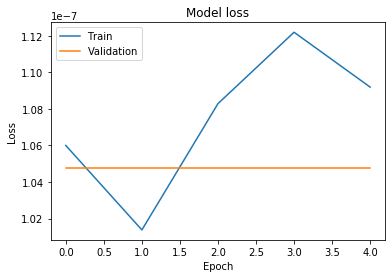

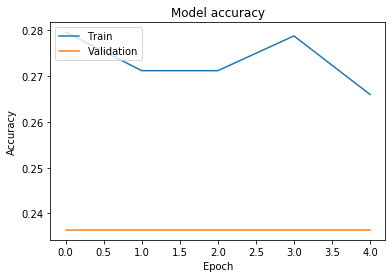

In [58]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [59]:
y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

rnn_acc = accuracy_score(y_pred, y_test)
rnn_prec = precision_score(y_pred, y_test,average='weighted')
rnn_rec = recall_score(y_pred, y_test,average='weighted')
rnn_f1 = f1_score(y_pred, y_test,average='weighted')

3125/3125 [==============================] - 14s 4ms/step


In [60]:
storeResults('RNN',rnn_acc,rnn_prec,rnn_rec,rnn_f1)

# CNN + LSTM

In [61]:
import tensorflow as tf
tf.keras.backend.clear_session()

model1 = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=1,padding="causal",activation="relu",input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(15)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                             decay_steps=1000000,
                                                             decay_rate=0.98,
                                                             staircase=False)

model1.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 64)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 128)           82432     
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [62]:
modelhistory = model1.fit(X_train, Y_train, epochs=5, verbose=1, validation_split=0.2, batch_size = 16)

Epoch 1/5
20000/20000 [==============================] - 147s 7ms/step - loss: 0.0221 - acc: 0.8289 - val_loss: 0.0159 - val_acc: 0.8351
Epoch 2/5
20000/20000 [==============================] - 142s 7ms/step - loss: 0.0171 - acc: 0.8358 - val_loss: 0.0158 - val_acc: 0.8351
Epoch 3/5
20000/20000 [==============================] - 156s 8ms/step - loss: 0.0165 - acc: 0.8363 - val_loss: 0.0157 - val_acc: 0.8351
Epoch 4/5
20000/20000 [==============================] - 138s 7ms/step - loss: 0.0160 - acc: 0.8407 - val_loss: 0.0150 - val_acc: 0.8424
Epoch 5/5
20000/20000 [==============================] - 139s 7ms/step - loss: 0.0160 - acc: 0.8436 - val_loss: 0.0166 - val_acc: 0.8421


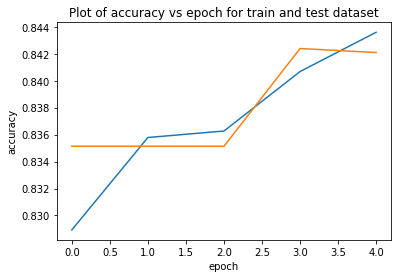

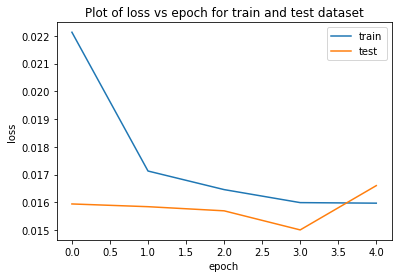

In [63]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(modelhistory.history['acc'])
plt.plot(modelhistory.history['val_acc'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plot of loss vs epoch for train and test dataset
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [64]:
y_pred = model1.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

ense_acc = accuracy_score(y_pred, y_test)
ense_prec = precision_score(y_pred, y_test,average='weighted')
ense_rec = recall_score(y_pred, y_test,average='weighted')
ense_f1 = f1_score(y_pred, y_test,average='weighted')

3125/3125 [==============================] - 13s 4ms/step


In [65]:
storeResults('CNN + LSTM',ense_acc,ense_prec,ense_rec,ense_f1)

# FNN

In [66]:
from tensorflow.keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm

In [67]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.20, random_state=42)

In [68]:
x_train = preprocessing.normalize(X_train)
x_test = preprocessing.normalize(X_test)

In [69]:
hidden_units = 10     # how many neurons in the hidden layer
activation = 'relu'   # activation function for hidden layer
l2 = 0.01             # regularization - how much we penalize large parameter values
learning_rate = 0.01  # how big our steps are in gradient descent
epochs = 5            # how many epochs to train for
batch_size = 2       # how many samples to use for each gradient descent update

In [70]:
# create a sequential model
model2 = models.Sequential()

# add the hidden layer
model2.add(layers.Dense(input_dim=14,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model2.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model2.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [71]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model2.fit(x_train, y_train, epochs=5, batch_size=batch_size,steps_per_epoch=1000, validation_steps=1000)

Epoch 1/5
1000/1000 [==============================] - ETA: 7:59 - loss: 0.7492 - accuracy: 0.50 - ETA: 0s - loss: 0.7331 - accuracy: 0.4365 - ETA: 0s - loss: 0.6312 - accuracy: 0.39 - ETA: 0s - loss: 0.3907 - accuracy: 0.35 - ETA: 0s - loss: 0.1222 - accuracy: 0.33 - ETA: 0s - loss: -0.0344 - accuracy: 0.310 - ETA: 0s - loss: -0.5290 - accuracy: 0.300 - ETA: 0s - loss: -0.7610 - accuracy: 0.299 - ETA: 0s - loss: -1.4149 - accuracy: 0.307 - ETA: 0s - loss: -1.6433 - accuracy: 0.305 - 1s 511us/step - loss: -1.6893 - accuracy: 0.3035
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: -79.5557 - accuracy: 0.0000e+ - ETA: 0s - loss: -6.8500 - accuracy: 0.3198     - ETA: 0s - loss: -7.8754 - accuracy: 0.356 - ETA: 0s - loss: -8.5201 - accuracy: 0.319 - ETA: 0s - loss: -8.8376 - accuracy: 0.310 - ETA: 0s - loss: -9.9567 - accuracy: 0.297 - ETA: 0s - loss: -12.5299 - accuracy: 0.29 - ETA: 0s - loss: -13.9318 - accuracy: 0.28 - ETA: 0s - loss: -15.4030 - accuracy: 0.26 - ET

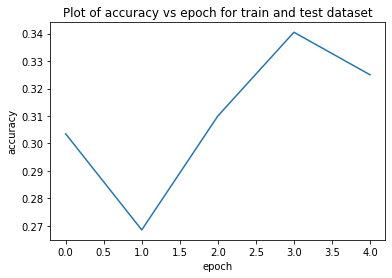

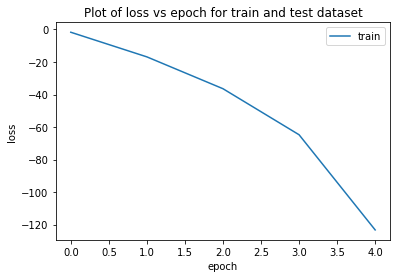

In [73]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [74]:
y_pred = model2.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dnn_acc = accuracy_score(y_pred, y_test)
dnn_prec = precision_score(y_pred, y_test,average='weighted')
dnn_rec = recall_score(y_pred, y_test,average='weighted')
dnn_f1 = f1_score(y_pred, y_test,average='weighted')

3125/3125 [==============================] - ETA: 1: - ETA: 1s - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 336us/step


In [75]:
storeResults('FNN',dnn_acc,dnn_prec,dnn_rec,dnn_f1)

# Transformer LSTM

In [76]:
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [77]:
from sklearn.model_selection import train_test_split
x_train1, x_test1 = train_test_split(X_reduced, test_size = 0.2, random_state = 0)

y_train1, y_test1 = train_test_split(y, test_size = 0.2, random_state = 0)

In [78]:
# normalize the data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train1)
x_test = scaler.transform(x_test1)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [79]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train1 = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
print("Training data shape:", X_train1.shape)
X_test1 = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
print("Test data shape:", X_test1.shape)

Training data shape: (400000, 1, 14)
Test data shape: (100000, 1, 14)


In [80]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [81]:
# create the autoencoder model
model_tl = autoencoder_model(X_train1)
model_tl.compile(optimizer='adam', loss='mae')
model_tl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 14)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1984      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 14)             238   

In [82]:
nb_epochs = 5
batch_size = 2
history = model_tl.fit(X_train1, X_train1, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05,steps_per_epoch=1000, validation_steps=1000).history

Epoch 1/5
1000/1000 [==============================] - ETA: 1:36:44 - loss: 0.05 - ETA: 1s - loss: 0.0616     - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.065 - ETA: 1s - loss: 0.065 - ETA: 1s - loss: 0.065 - ETA: 1s - loss: 0.065 - ETA: 1s - loss: 0.065 - ETA: 0s - loss: 0.065 - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.062 - 9s 3ms/step - loss: 0.0622 - val_loss: 0.0412
Epoch 2/5
1000/1000 [==============================] - ETA: 5s - loss: 0.011 - ETA: 1s - loss: 0.034 - ETA: 1s - loss: 0.037 - ETA: 1s - loss: 0.038 - ETA: 1s - loss: 0.038 - ETA: 1s - loss: 0.038 - ETA: 1s - loss: 0.037 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.0

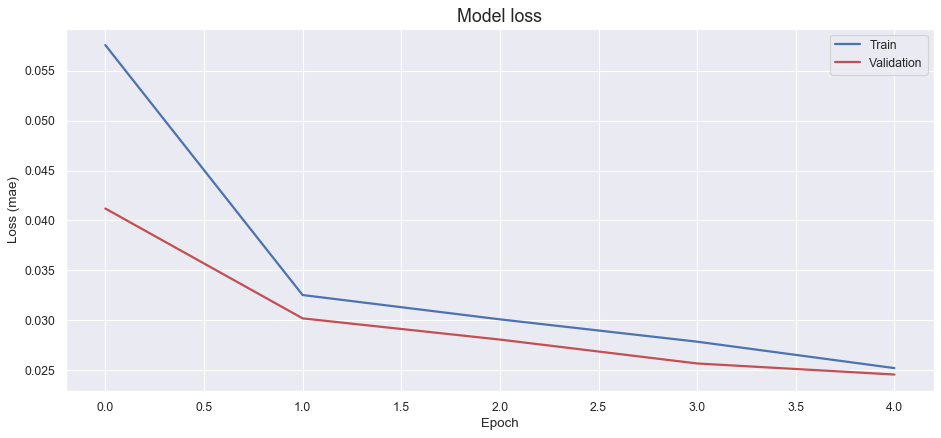

In [83]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [88]:
# Convert predicted probabilities to class labels if necessary
# For binary classification
y_pred = (y_pred > 0.5).astype(int)

# For multiclass classification
# y_pred = np.argmax(y_pred, axis=1)

# Now compute classification metrics
tl_prec = precision_score(y_test, y_pred, average='weighted')
tl_rec = recall_score(y_test, y_pred, average='weighted')
tl_f1 = f1_score(y_test, y_pred, average='weighted')


In [89]:
storeResults('Transformer LSTM',tl_acc,tl_prec,tl_rec,tl_f1)

# Transformer - Encoder and Decoder

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, random_state=1)

In [92]:
import matplotlib.pyplot as plt
n_train = np.array(X_train)
n_test = np.array(X_test)

14
(335000, 14)


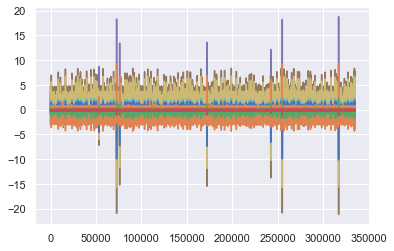

In [93]:
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf

input_dim = n_train.shape[1]
feature_dim = [25, 20, 15, 10]
print(input_dim)
inputs = Input(shape=(input_dim,))
encoded = inputs
encoded = Dense(feature_dim[0], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[1], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[2], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[3], kernel_initializer="uniform")(encoded)

decoded = encoded
decoded = Dense(feature_dim[2], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[1], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[0], kernel_initializer="uniform")(decoded)
decoded = Dense(input_dim, kernel_initializer="uniform")(decoded)


autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(n_train, n_train,
                verbose=0,
                epochs=5,
                batch_size=2,
                shuffle=True,
                validation_data=(n_test, n_test),
               steps_per_epoch=500,
               validation_steps=500)

predict_vals = autoencoder.predict(n_train)
print(predict_vals.shape)
plt.plot(predict_vals)
plt.show()

In [94]:
from keras.models import Sequential

featuremodel = Sequential()
featuremodel.add(Dense(feature_dim[0], input_shape=(input_dim,), weights=autoencoder.layers[1].get_weights()))
featuremodel.add(Dense(feature_dim[1], weights=autoencoder.layers[2].get_weights()))
featuremodel.add(Dense(feature_dim[2], weights=autoencoder.layers[3].get_weights()))
featuremodel.add(Dense(feature_dim[3], weights=autoencoder.layers[4].get_weights()))

featuremodel.compile(optimizer='adadelta', loss='mse')

In [95]:
y_pred = autoencoder.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

ende_acc = accuracy_score(y_pred, y_test)
ende_prec = precision_score(y_pred, y_test,average='weighted')
ende_rec = recall_score(y_pred, y_test,average='weighted')
ende_f1 = f1_score(y_pred, y_test,average='weighted')

5157/5157 [==============================] - ETA: 2: - ETA: 6s - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 694us/step


In [96]:
storeResults('Transformer Encode-Decode',ende_acc,ende_prec,ende_rec,ende_f1)

# Comparison

In [97]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score
                      })

In [98]:
result

,ML Model,Accuracy,Precision,Recall,F1-Score
0,SVM,0.664,0.597,0.664,0.626
1,Bagging Classifier,0.997,0.998,0.997,0.998
2,Voting Classifier,0.997,0.997,0.997,0.997
3,LSTM,0.835,1.000,0.835,0.910
4,RNN,0.835,1.000,0.835,0.910
5,CNN + LSTM,0.842,0.990,0.842,0.906
6,FNN,0.835,1.000,0.835,0.910
7,Transformer LSTM,0.975,0.814,0.506,0.623
8,Transformer Encode-Decode,0.480,0.541,0.480,0.404


# MOdelling

In [99]:
import joblib
filename = 'model_cicids2017.sav'
joblib.dump(eclf1, filename)

['model_cicids2017.sav']

# Graph

In [100]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

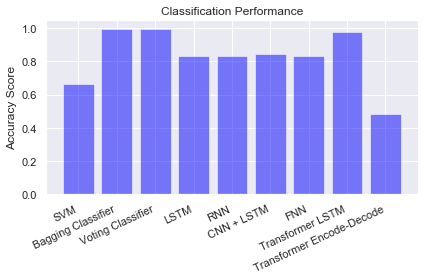

In [118]:
import matplotlib.pyplot as plt2

# Example data (assuming you have these variables defined)
# y_pos = [0, 1, 2]  # Example indices
# accuracy = [0.8, 0.6, 0.9]  # Example accuracy scores
# classifier = ['Classifier A', 'Classifier B', 'Classifier C']

y_pos = range(len(classifier))

# Swap axes by using bar instead of barh
plt.bar(y_pos, accuracy, align='center', alpha=0.5, color='blue')

# Add x-tick labels for classifiers and rotate them for better readability
plt.xticks(y_pos, classifier, rotation=25, ha='right')

# Add axis labels and title
plt.ylabel('Accuracy Score')

plt.title('Classification Performance')

# Display the plot
plt.tight_layout()  # Ensures proper spacing of elements
plt.show()

# Precision

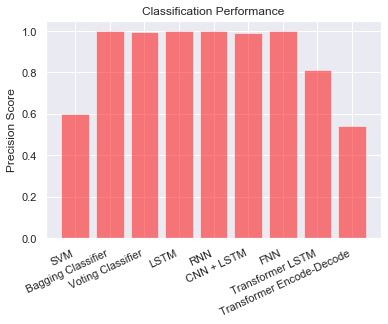

In [115]:
plt2.bar(y_pos, precision, align='center', alpha=0.5, color='red') # Change to bar()
plt.xticks(y_pos, classifier, rotation=25, ha='right')
plt2.xticks(y_pos, classifier)  # Update from yticks to xticks
plt2.ylabel('Precision Score')   # Update from xlabel to ylabel
plt2.title('Classification Performance')
plt2.show()

# Recall

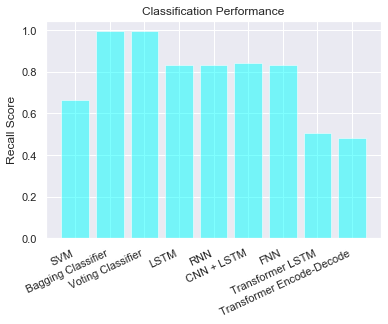

In [116]:
import matplotlib.pyplot as plt2

# Example data (assuming you have these variables defined)
# y_pos = [0, 1, 2]  # Example indices
# recall = [0.85, 0.75, 0.65]  # Example recall scores
# classifier = ['Classifier A', 'Classifier B', 'Classifier C']

plt2.bar(y_pos, recall, align='center', alpha=0.5, color='cyan')  # Change to bar()
plt.xticks(y_pos, classifier, rotation=25, ha='right')

plt2.xticks(y_pos, classifier)  # Update from yticks to xticks
plt2.ylabel('Recall Score')     # Update from xlabel to ylabel
plt2.title('Classification Performance')
plt2.show()


# F1 Score

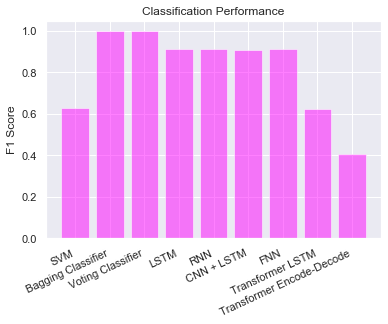

In [117]:
import matplotlib.pyplot as plt2

# Example data (assuming you have these variables defined)
# y_pos = [0, 1, 2]  # Example indices
# f1score = [0.8, 0.7, 0.9]  # Example F1 scores
# classifier = ['Classifier A', 'Classifier B', 'Classifier C']

plt2.bar(y_pos, f1score, align='center', alpha=0.5, color='magenta')  # Change to bar()
plt.xticks(y_pos, classifier, rotation=25, ha='right')
plt2.xticks(y_pos, classifier)  # Update from yticks to xticks
plt2.ylabel('F1 Score')         # Update from xlabel to ylabel
plt2.title('Classification Performance')
plt2.show()
